In [2]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from transformers import MarianMTModel, MarianTokenizer # MT: Machine Translation
import pandas as pd
from tqdm import tqdm
import math, random
from einops import rearrange

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

print(DEVICE)

/data/anaconda3/envs/layoutlm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-ko-en')
model = MarianMTModel.from_pretrained('Helsinki-NLP/opus-mt-ko-en')

/data/anaconda3/envs/layoutlm/lib/python3.11/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [4]:
eos_idx = tokenizer.eos_token_id
pad_idx = tokenizer.pad_token_id
print("eos_idx = ", eos_idx)
print("pad_idx = ", pad_idx)

eos_idx =  0
pad_idx =  65000


In [5]:
BATCH_SIZE = 64 # 논문에선 2.5만 token이 한 batch에 담기게 했다고 함.
LAMBDA = 0 # l2-Regularization를 위한 hyperparam. # 저장된 모델
EPOCH = 15 # 저장된 모델
# max_len = 512 # model.model.encoder.embed_positions 를 보면 512로 했음을 알 수 있다.
max_len = 100 # 너무 긴거 같아서 자름 (GPU 부담도 많이 덜어짐)
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx) # pad token 이 출력 나와야하는 시점의 loss는 무시 (즉, label이 <pad> 일 때는 무시) # 저장된 모델
scheduler_name = 'Noam'
#### Noam ####
# warmup_steps = 4000 # 이건 논문에서 제시한 값 (총 10만 step의 4%)
warmup_steps = 1000 # 데이터 수 * EPOCH / BS = 총 step 수 인것 고려 # 저장된 모델
LR_scale = 0.5 # Noam scheduler에 peak LR 값 조절을 위해 곱해질 녀석 # 저장된 모델
#### Cos ####
LR_init = 5e-4
T0 = 1500 # 첫 주기
T_mult = 2 # 배 만큼 주기가 길어짐 (1보다 큰 정수여야 함)
#############

In [6]:
vocab_size = tokenizer.vocab_size
print(vocab_size)

65001


In [7]:
# 좀 사이즈 줄인 모델 (훈련된 input_embedding, fc_out 사용하면 사용 불가)
n_layers = 3
d_model = 256
d_ff = 512
n_heads = 8
drop_p = 0.1

In [8]:
print(tokenizer.tokenize("확실히 띄어쓰기 기준으로 토크나이징을 하는 것 같진 않다."))
print(tokenizer.tokenize("여러분들 차례!"))

['▁확실히', '▁띄', '어', '쓰기', '▁기준으로', '▁토', '크', '나이', '징', '을', '▁하는', '▁것', '▁같', '진', '▁않다', '.']
['▁여러분들', '▁차례', '!']


In [9]:
input_text = "헐! 대박 쩐다!"
input_tokens = tokenizer.encode(input_text, return_tensors="pt")
translated_tokens = model.generate(input_tokens, max_new_tokens=max_len)
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)

print("입력:", input_text)
print("AI 번역:", translated_text)

tokens = tokenizer.tokenize("헐! 대박 쩐다!")
print(tokens)
print(input_tokens)

입력: 헐! 대박 쩐다!
AI 번역: Oh, my God! That's awesome!
['▁헐', '!', '▁대박', '▁', '쩐', '다', '!']
tensor([[19458,    28, 41999,     9, 58809,   161,    28,     0]])


In [10]:
# !gdown https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t -O '대화체.xlsx'
# data = pd.read_excel('대화체.xlsx')

Downloading...
From: https://drive.google.com/uc?id=1r4ZnFJOStyBlNRx7snBQ-Iq2GNyJKL6t
To: /home/yjhwang/workspace/Transformer/대화체.xlsx
100%|██████████████████████████████████████| 9.57M/9.57M [00:00<00:00, 17.2MB/s]


In [18]:
data = pd.read_excel('대화체.xlsx')

In [19]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, idx):
        return self.data.loc[idx, '원문'], self.data.loc[idx, '번역문']
    
custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [97000, 2000, 1000])

train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size = BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle=True)

print(len(train_DL))
print(len(val_DL))
print(len(test_DL))

48500
1000
500


In [31]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return self.data.shape[0]
    def __getitem__(self, index):
        return self.data.loc[index, '원문'], self.data.loc[index, '번역문']
    
custom_DS = CustomDataset(data)
train_DS, val_DS, test_DS = torch.utils.data.random_split(custom_DS, [97000,2000,1000])

BATCH_SIZE = 16
train_DL = torch.utils.data.DataLoader(train_DS, BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, BATCH_SIZE, shuffle=True)

In [32]:
idx = 1
src_text, trg_text = train_DS[idx]

print(f"인덱스: {test_DS.indices[idx]}")
print(f"원문: {src_text}")
print(f"번역문: {trg_text}")


인덱스: 12605
원문: 4월 7일부터 한 주간 있다가 올 거 같아.
번역문: It'll probably be for a week starting on the 7th of April.


In [62]:
src_texts, trg_texts = next(iter(train_DL))

print(src_texts)
print(trg_texts)
print(len(src_texts))
print(len(trg_texts))

src = tokenizer(src_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt', add_special_tokens=False).input_ids
trg_texts = ['</s>' + s for s in trg_texts]
trg = tokenizer(trg_texts, padding=True, truncation=True, max_length=max_len, return_tensors='pt', add_special_tokens=True).input_ids

print(src.shape)
print(trg.shape)
print("="*100)
print(trg[:,-1])
print(trg[:,-1]==eos_idx)
# print(tokenizer.decode(trg[trg[:,-1]==eos_idx,:])[0])
# print(trg[trg[:,-1]==eos_idx])
# print(trg[trg[:,-1]==eos_idx,:])
# print(trg[trg[:,-1]==eos_idx][0])
print(tokenizer.decode(trg[trg[:,-1]==eos_idx][0]))
print("="*100)
print("디코더 입력:\n")
# print(trg[5,:-1])
print(tokenizer.decode(trg[5,:-1]))
print("디코더 출력:\n")
# print(trg[5,1:])
print(tokenizer.decode(trg[5,1:]))

('다른 사람들이 입어보고 한 진열제품은 가져가기가 그런데, 아니면 금액을 깎아주세요.', '진짜 모차렐라 치즈를 듬뿍 넣어서 만든 느낌이야.', '어떡할래? 우리 그냥 다른 음식점으로 갈까?', '아니에요, 점수에 의구심이 든다면 당연히 확인해야지요.', '영상 자료를 틀어야 해서 시청각실로 함께 가시죠.', '큰길 사거리에서 오른쪽 길로 가서 5분 정도 걸어가면 있습니다.', '네, 지금 바로 검은색으로 변경해드리도록 하겠습니다.', '다음 주까지 필요한데 가능한지 확인 좀 해주세요.', '그 터키 공장은 우리와 이번에 처음 거래하는 업체이니, 저희 쪽에서는 딱히 방법이 없어요.', '지방을 제거해서 꺼진 부위에 메워주는 거예요.', '제가 지금 바로 차를 타는데, 효과가 있을까요?', '벌써요? 그렇다면 바다 전망이 아니라도 경치가 좋은 객실로 부탁드려요.', '저기에 안내해주시는 분이 있으니까 한번 여쭤볼까?', '정지를 푸는 것은 가능한데, 지금 신규 카드가 발송 중인데 괜찮으실까요?', '저번 영화는 재미있게 봤는데, 이 영화는 어떨지 모르겠네.', '이번 달 예산이 좀 빠듯한데, 어디 저렴한 미용실 없나?')
("I'm relucted to buy the displayed product since it has been worn by someone else, or please offer a discount.", "It's like they made it with real mozzarella cheese.", 'What do you want to do? Shall we go to another restaurant?', 'No, if you have any doubts about the score, you should check it out to make sure.', "Let's go to the audiovisual room together because we have to turn on the video.", 'Walk 5 minutes from 

In [119]:
# 내가 쓸 train data에 대해서 MarianMTmodel 이 잘 번역하는지 확인
src_text, trg_text = train_DS[7]
print(f"입력: {src_text}")
print(f"정답: {trg_text}")

src = tokenizer.encode(src_text, return_tensors="pt", add_special_tokens=True)
# print(src)
translated_tokens = model.generate(src, max_new_tokens=max_len)
translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=False)

print(f"AI의 번역: {translated_text}") # 디코더 첫 입력으로 <pad> 토큰을 넣었음. (<pad>를 <sos>로 사용)
print(src.shape)


입력: 바지 허리 안쪽에 제품명이 적혀 있을 텐데 불러주시겠어요?
정답: There should be the product name written on the inside of the pants' waist so could you please tell me?
AI의 번역: <pad> There's a product name in the back of your pants, so can you call it?</s>
torch.Size([1, 13])


In [115]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.fc_q = nn.Linear(d_model,d_model)
        self.fc_k = nn.Linear(d_model,d_model)
        self.fc_v = nn.Linear(d_model,d_model)
        self.fc_o = nn.Linear(d_model,d_model)

        self.scale = torch.sqrt(torch.tensor(d_model/n_heads))

    def forward(self, Q, K, V, mask=None):
        Q = self.fc_q(Q)
        K = self.fc_q(K)
        V = self.fc_q(V)

        Q = rearrange(Q, '개 단 (헤, 차) -> 개 헤 단 차', 헤=self.n_heads)
        K = rearrange(K, '개 단 (헤, 차) -> 개 헤 단 차', 헤=self.n_heads)
        V = rearrange(V, '개 단 (헤, 차) -> 개 헤 단 차', 헤=self.n_heads)

        attention_score = Q @ K.transpose(-2,-1) / self.scale # 개헤단단

        if mask is not None:
            attention_score[mask] = -1e10

        attention_weights = torch.softmax(attention_score, dim=-1) # 개헤단단

        attention = attention_weights @ V # 개헤단차

        x = rearrange(attention, '개 헤 단 차 -> 개 단 (헤 차)') #개헤단차 -> 개단차
        x = self.fc_o(x) # 개단차

        return x, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()
        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.ReLu(),
                                    nn.Dropout(drop_p), # 논문에는 명시되어 있지 않지만, overfiiting 에 취약한 부분이랑 도입함
                                    nn.Linear(d_ff, d_model))
    
    def forward(self, x):
        x = self.linear(x)
        return x

In [116]:
Q = torch.randn(1, 4, 6) # 개 단 차
print(Q)

Q = rearrange(Q, '개 단 (헤 차) -> 개 헤 단 차', 헤 = 3) # 개단차 -> 개헤단차
print(Q)
print(Q.shape)

x = rearrange(Q, '개 헤 단 차 -> 개 단 (헤 차)') # 개헤단차 -> 개단차
print(x)
print(x.shape)

tensor([[[-1.2795, -0.4690, -0.3812, -1.8215,  1.0798,  0.4535],
         [ 1.1228,  1.0303, -3.2004,  0.4480, -0.1293,  1.1134],
         [-0.4729,  0.8782, -0.5438, -0.8563,  0.2273,  0.1965],
         [ 0.6570, -1.1602, -0.6621, -0.7642,  0.4658, -1.1762]]])
tensor([[[[-1.2795, -0.4690],
          [ 1.1228,  1.0303],
          [-0.4729,  0.8782],
          [ 0.6570, -1.1602]],

         [[-0.3812, -1.8215],
          [-3.2004,  0.4480],
          [-0.5438, -0.8563],
          [-0.6621, -0.7642]],

         [[ 1.0798,  0.4535],
          [-0.1293,  1.1134],
          [ 0.2273,  0.1965],
          [ 0.4658, -1.1762]]]])
torch.Size([1, 3, 4, 2])
tensor([[[-1.2795, -0.4690, -0.3812, -1.8215,  1.0798,  0.4535],
         [ 1.1228,  1.0303, -3.2004,  0.4480, -0.1293,  1.1134],
         [-0.4729,  0.8782, -0.5438, -0.8563,  0.2273,  0.1965],
         [ 0.6570, -1.1602, -0.6621, -0.7642,  0.4658, -1.1762]]])
torch.Size([1, 4, 6])


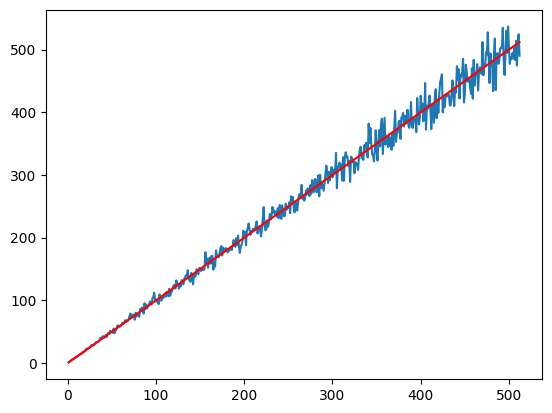

In [111]:
# 왜 scaling 을 sqrt(dk)로? <- 일단 나누는 이유: 안나누면 softmax 로 들어갈 때 분산이 크면 grad 가 작아짐
# 이 실험은 차원이 증가할수록, 난수 벡터들의 내적값의 분산이 차원(ni)에 비례하여 증가하는지 확인하는 것입니다.
# 내적값의 분산이 n과 거의 동일하게 증가함 의미한다.
import matplotlib.pyplot as plt

n = torch.arange(1,513)
N=1000
result=[]
for ni in n:
    inner_prod = torch.zeros(N)
    for i in range(N):
        inner_prod[i] = torch.randn(ni,1).T@torch.randn(ni,1) # 내적값을 N번 구해서 var 구해보자
    result += [torch.var(inner_prod)] 

plt.plot(n,result)
plt.plot(n,n,'r')


In [141]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_attention = MHA(d_model, n_heads)
        self.self_attention_LN = nn.LayerNorm(d_model)

        self.FF = FeedForward(d_model, d_ff, n_heads)
        self.FF_LN = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, enc_mask):
        residual, atten_enc = self.self_attention(x, x, x, enc_mask) # 인코더에도 마스크가?
        residual = self.dropout(residual)
        x = self.self_attention_LN(x + residual)

        residual = x
        x = self.FF(x)
        x = self.dropout(x)
        x = self.FF_LN(x + residual)

        return x, atten_enc

class Encoder(nn.Module):
    def __init__(self, input_embedding, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.scale = torch.sqrt(torch.tensor(d_model))
        self.input_embedding = input_embedding
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([EncoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])
    
    def forward(self, src, mask, atten_map_save=False): # src.shape = 개,단, mask.shape 개헤단단
        pos = torch.arange(src.shape[1]).expand_as(src).to(DEVICE)

        x = self.scale * self.input_embedding(src) + self.pos_embedding(pos)
        # self.scale 을 곱해주면 position 보다 token 정보를 더 보게 된다. (gradient 에 self.scale 만큼이 곱해진다.)
        x = self.dropout(x)

        atten_encs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_encs = layer(x, mask)
            if atten_map_save:
                atten_encs = torch.cat([atten_encs, atten_encs[0].unsqueeze(0)], dim=0)
        
        return x, atten_encs

In [ ]:
src = torch.randint(0,65000,(3,5)) # 개단
pos = torch.arange(5).expand_as(src).to(DEVICE)

In [140]:
max_len = 10
d_model = 20

embedding = nn.Embedding(max_len, d_model)

pos_ids = torch.arange(0,5)
positional_vector = embedding(pos_ids)

pos_ids_ = torch.tensor([1,1,1,1,1])
positional_vector_ = embedding(pos_ids_)

print(positional_vector)
print('='*100)
print(positional_vector_)

tensor([[ 1.8863,  0.8326, -0.2832, -1.1252,  0.7506,  1.0816, -0.8797, -1.5239,
         -0.2150, -0.4862, -0.8422, -1.0010,  1.2718, -1.8768, -0.5476,  1.5660,
          0.0785,  0.5832,  1.3463, -0.3878],
        [-0.6907,  1.3832,  1.1707,  0.6680, -1.1032, -0.2991,  1.6492,  0.4183,
         -0.7704, -0.4523,  1.0389, -0.3763, -0.3834,  0.3212,  2.7308,  0.7158,
         -0.4916, -0.8561, -2.6000,  1.7570],
        [ 0.4966, -0.0800, -0.3938, -0.5632, -0.0165,  0.2307, -1.2475,  1.1656,
          0.4449, -0.3076, -1.5482,  1.1797,  1.5518, -0.4405,  1.3124, -2.1919,
         -0.6945,  0.0176, -0.0185, -1.3151],
        [ 0.3225, -0.1522, -1.5477, -0.0724, -1.4993, -0.1069, -0.4517, -0.0448,
         -1.8946,  0.0217, -1.2227,  0.8320, -0.8686, -1.7930,  0.0694,  0.9696,
          1.5385, -0.0140, -2.2654, -1.6096],
        [ 1.2950,  0.9047,  0.6619, -0.5535,  0.7737, -0.2892, -0.5585, -0.6547,
          1.0174, -0.7845, -1.3931,  1.6341,  0.3953, -0.4371, -0.6300,  0.7081,
      

In [150]:
a = torch.tensor([[1, 2], [3, 4]])  # (2, 2)
b = torch.tensor([[5, 6, 1], [1,1,1]])  # (1, 2)

result = torch.cat([a, b], dim=1)  # (세로 방향으로 연결)
print(result)

tensor([[1, 2, 5, 6, 1],
        [3, 4, 1, 1, 1]])
